# AN ENERGY MARKET ANALYSIS TOOL

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

## Dataset: 

The Australian Energy Market Operator (AEMO) currently covers 5 Areas: Queensland (QLD),  Victoria (VIC), New South Wales (NSW), Tasmania (TAS) and South Australia (SA).

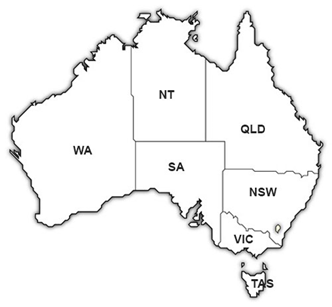

 - Region - Queensland (QLD),  Victoria (VIC), New South Wales (NSW), Tasmania (TAS) and South Australia (SA).
 - Settlement Date (half-hour interval)
 - Total Area Demand (in MWh)
 - Spot Price (RRP - in Australian dollars)
 - PeriodType (Always TRADE - Not Applicable in our analysis)
 
 Spanning 6 years from 2014 to 2019, 2191 days in total for 5 areas and with 48 half-hour intervals per day.

## Keywords and important notes:

- BESS : Battery Energy storage system (i.e. batteries)
- AUD: Australian Dollars
- MWh : Megawatt-hour, energy unit representing total energy produced/consumed in one hour with a power of 1 MW
- MW: Megawatt, 1 million watts, power unit. An average household in US would requires about 1.25 KW = 0.00125 MW on average
- Time interval for each spot price point is 0.5 hours, which means each day consists of 48 spot prices.

We want to optimize the strategy of buying/selling with the aim to maximize total revenue.

## Assumptions:

- Day ahead optimization (we are assuming that we know the prices one day ahead).
- We do not influence the prices in the market with our activity
- Maximum BESS energy capacity is 500 MWh
- Maximum BESS power rating is 100 MW
- Round-Trip efficiency is 0.87 - i.e. If the battery has an initial energy of 100MW one full discharge and then full charge of the battery at 100MW for one hour will result in 87MWh stored in the battery. One way efficiency is the square-root of 0.87
- Initial stored energy in the BESS is 0 MWh.
- OPEX is 0

CAPEX is around $35M

In [6]:
df_QLD = pd.read_pickle('resultQLD.pkl')
df_VIC = pd.read_pickle('resultVIC.pkl')
df_NSW = pd.read_pickle('resultNSW.pkl')
df_TAS = pd.read_pickle('resultTAS.pkl')
df_SA = pd.read_pickle('resultSA.pkl')

df_QLD.head(5)

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE,POWERS,ENERGIES,OPTIMALREVENUE
0,QLD1,2014/01/01 00:30:00,5515.63,52.45,TRADE,-0.012812,0.005975,-0.335993
1,QLD1,2014/01/01 01:00:00,5376.30,50.20,TRADE,0.002751,0.004500,0.069060
2,QLD1,2014/01/01 01:30:00,5214.38,46.66,TRADE,0.001479,0.003809,0.034494
3,QLD1,2014/01/01 02:00:00,5149.08,42.85,TRADE,-100.000000,46.640704,-2142.500000
4,QLD1,2014/01/01 02:30:00,5051.84,38.49,TRADE,-100.000000,93.277600,-1924.500000


## Optimization and further results

We used a constraint optimization algorithm from the `scipy.optimize` library package. Specifically, the `minimize` function with algorithm `SLSQP` to derive the optimal operational mode in order to maximize profit. Analysis was performed for the entire dataset.

Let us see how the output of the optimization algorithm looks like in energies, powers of batteries and prices in a typical 48-interval duration (DAY 3):

In [90]:
dailyRevenue = df_QLD.OPTIMALREVENUE.rolling(48).sum()[list(range(47,len(df_QLD),48))].reset_index(drop=True)

print('DAILY REVENUE AT DAY 3 IS', dailyRevenue[2], 'AUD')



DAILY REVENUE AT DAY 3 IS 57035.58973796928 AUD


Text(0, 0.5, 'POWER (MW)')

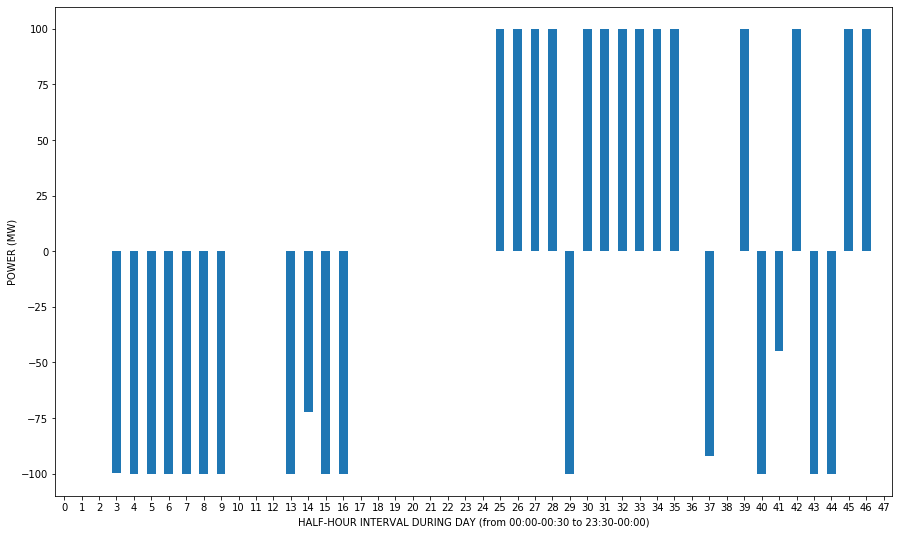

In [82]:
powers = df_QLD.POWERS[2*48:3*48].reset_index(drop=True)
energies = df_QLD.ENERGIES[2*48:3*48].reset_index(drop=True)
prices = df_QLD.RRP[2*48:3*48].reset_index(drop=True)

ax = powers.plot.bar(rot=0, figsize=(15,9))

ax.set_xlabel('HALF-HOUR INTERVAL DURING DAY (from 00:00-00:30 to 23:30-00:00)')
ax.set_ylabel('POWER (MW)')

Text(0, 0.5, 'ENERGY (MWh)')

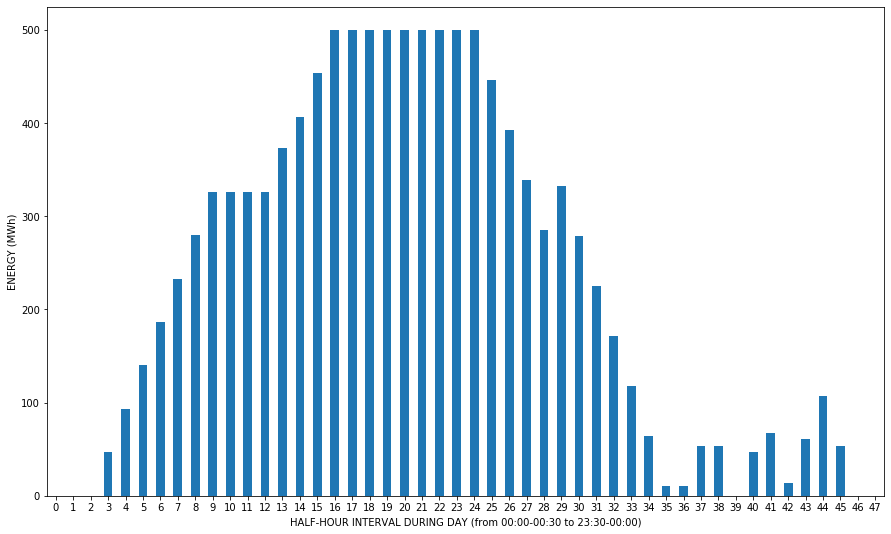

In [85]:
ax2 = energies.plot.bar(rot=0, figsize=(15,9))
ax2.set_xlabel('HALF-HOUR INTERVAL DURING DAY (from 00:00-00:30 to 23:30-00:00)')
ax2.set_ylabel('ENERGY (MWh)')

Text(0, 0.5, 'AUD')

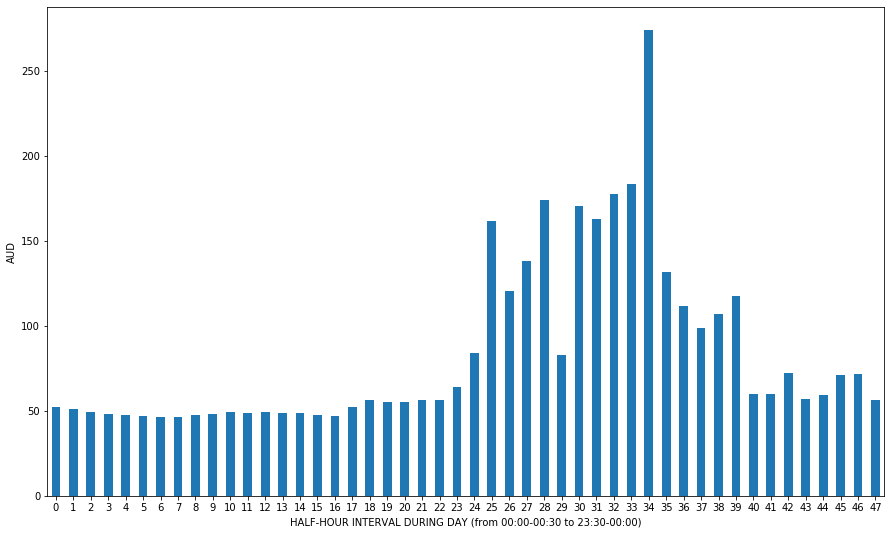

In [84]:
ax3 = prices.plot.bar(rot=0,figsize=(15,9))
ax3.set_xlabel('HALF-HOUR INTERVAL DURING DAY (from 00:00-00:30 to 23:30-00:00)')
ax3.set_ylabel('AUD')


The above optimization resulted in three more fields in our dataset corresponding to:

 - Power utilization of battery (Negative is charging the batteries and positive is discharging)
 - Energy stored at the battery (Ranging from 0 to 500 MWh according to constraints)
 - Optimal revenue generated (based on the above assumptions) separated in half-hour intervals - When batteries are charged we have negative revenue, when discharched we have positive revenue.

## TOTAL REVENUE PER AREA (2014-2020):

Text(0, 0.5, 'TOTAL REVENUE (AUD)')

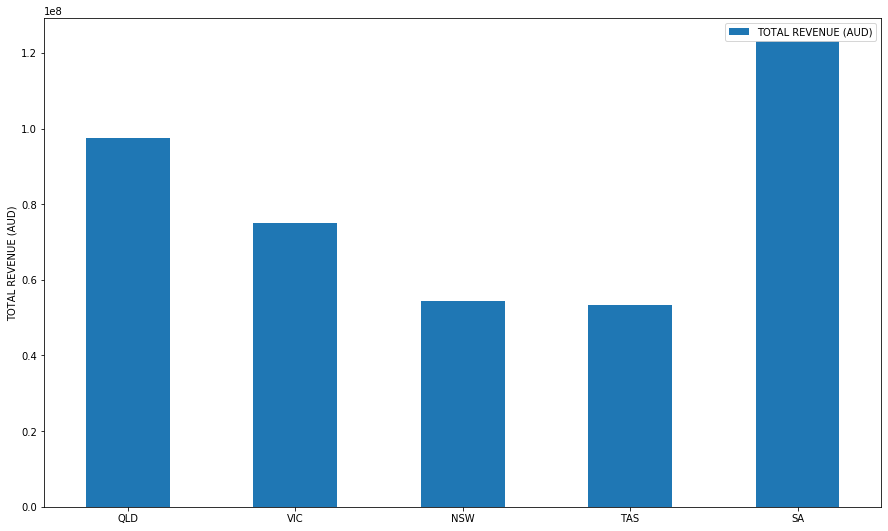

In [115]:
regions = ['QLD', 'VIC', 'NSW', 'TAS', 'SA']
df_revenues = pd.DataFrame({'TOTAL REVENUE (AUD)': [df_QLD.OPTIMALREVENUE.sum(), \
                                            df_VIC.OPTIMALREVENUE.sum(), \
                                            df_NSW.OPTIMALREVENUE.sum(), \
                                            df_TAS.OPTIMALREVENUE.sum(), \
                                            df_SA.OPTIMALREVENUE.sum()]}, \
                          index = regions)
ax = df_revenues.plot.bar(rot=0,figsize=(15,9))

ax.set_ylabel('TOTAL REVENUE (AUD)')

From this graph it would seem that the best region to invest and operate BESS (yieling the higher profit) is SA. But, if we look at our assumptions we can see that one of them states that the prices on the market are not influenced by our presence. In reality we influence the market prices with our presence when we buy because we increase the total energy demand (hence the price) and when we sell because we increase the supply (hence lowering the price).

So it would be more intuitive to have a perspective of how much we influence the market. This is proportionate to how much energy we buy/sell with respect to the total energy demand which is a measure of how much energy is moving to the market.

## TOTAL REVENUE PER AREA INCLUDING AVERAGE DEMAND:

Text(0, 0.5, 'AVERAGE DEMAND IN ONE INTERVAL (MWh)')

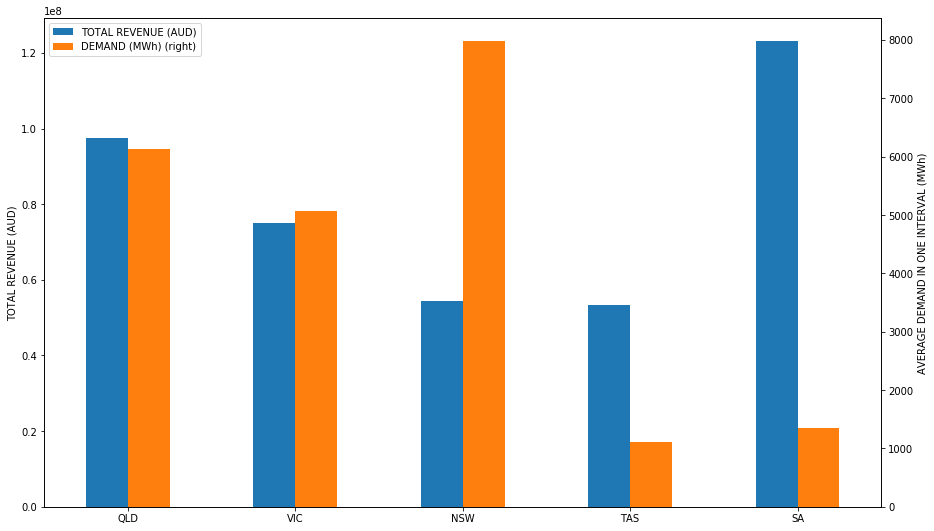

In [114]:
df_demand = pd.DataFrame({'DEMAND (MWh)': [df_QLD.TOTALDEMAND.mean(), \
                              df_VIC.TOTALDEMAND.mean(), \
                              df_NSW.TOTALDEMAND.mean(), \
                              df_TAS.TOTALDEMAND.mean(), \
                              df_SA.TOTALDEMAND.mean()]}, index = regions)

df_rev_demand = pd.concat([df_revenues, df_demand], axis=1)

df_rev_demand.head(5)

ax = df_rev_demand.plot( kind = 'bar', secondary_y = 'DEMAND (MWh)', rot= 0,figsize=(15,9))
ax.set_ylabel('TOTAL REVENUE (AUD)')
ax.right_ax.set_ylabel('AVERAGE DEMAND IN ONE INTERVAL (MWh)')


We can see that the average demand in SA, where arbitrage yields the highest revenue, is around 5 times lower than QLD which yields the second highest revenue. Since in each interval we provide 50 MWh which is ~ 4% of the total demand, it is much more likely to influence the prices in SA at the expense of profit, than if we invest in QLD where our demand/supply of 50 MWh is only ~ 0.8% of the total demand.

Another important aspect of investment in BESS is battery life which is usually measured in roundtrip charge/discharge cycles. This cost should be factored in the operational costs and it can be directly factored in as cost per MWh. It would be therefore important to have a measure of the profit per MWh per area.

## REVENUE PER MWh PER AREA:

In [104]:
df_totalEnergies = pd.DataFrame({'TOTAL ENERGIES EXCHANGED WITH NETWORK (MWh)': [df_QLD.POWERS.abs().sum()*0.5, \
                                            df_VIC.POWERS.abs().sum()*0.5, \
                                            df_NSW.POWERS.abs().sum()*0.5, \
                                            df_TAS.POWERS.abs().sum()*0.5, \
                                            df_SA.POWERS.abs().sum()*0.5]}, \
                          index = regions)

df_totalEnergies

,TOTAL ENERGIES EXCHANGED WITH NETWORK (MWh)
QLD,2.993505e+06
VIC,3.090402e+06
NSW,2.735084e+06
TAS,2.629886e+06
SA,3.170850e+06


In [106]:
df_revenues['REVENUE PER MWh (AUD)'] = \
df_revenues['TOTAL REVENUE (AUD)'] / df_totalEnergies['TOTAL ENERGIES EXCHANGED WITH NETWORK (MWh)']

df_revenues

,TOTAL REVENUE (AUD),REVENUE PER MWh (AUD)
QLD,9.742709e+07,32.546161
VIC,7.505763e+07,24.287337
NSW,5.447044e+07,19.915459
TAS,5.344073e+07,20.320552
SA,1.231690e+08,38.844148


Text(0, 0.5, 'REVENUE PER MWh (AUD)')

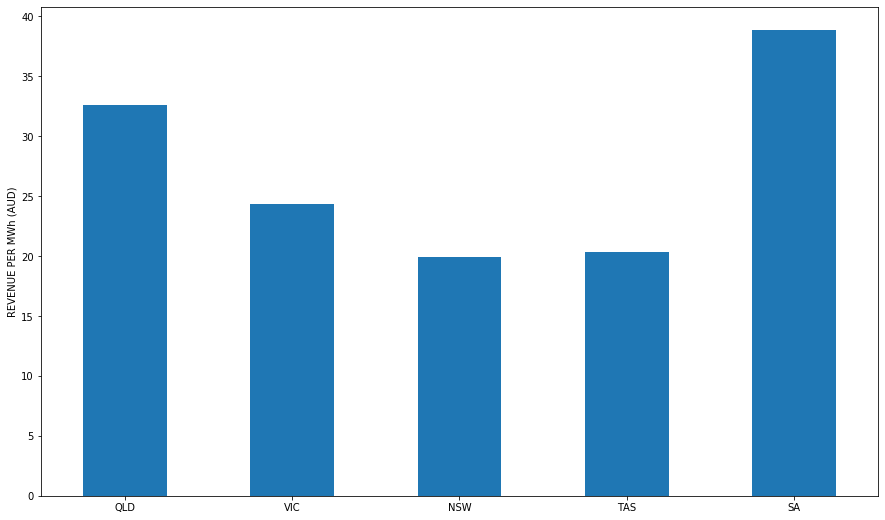

In [109]:
ax = df_revenues['REVENUE PER MWh (AUD)'].plot.bar(rot=0,figsize=(15,9))
ax.set_ylabel('REVENUE PER MWh (AUD)')

As observed this does not change the distribution of profit between regions, however now we can have a better feel of the revenue and if we can factor in the OPEX per MWh we can make a more accurate estimation of the ROI and profit.

## CORRELATION OF PROFIT WITH STANDARD DEVIATION:

The optimization algorithm takes a few seconds up to a few minutes to complete for each set of 48 half-hour intervals. It would be good to have an estimate of the profitability for each day based on a simpler calculation. Intuitively, the standard deviation might be a good first choice:

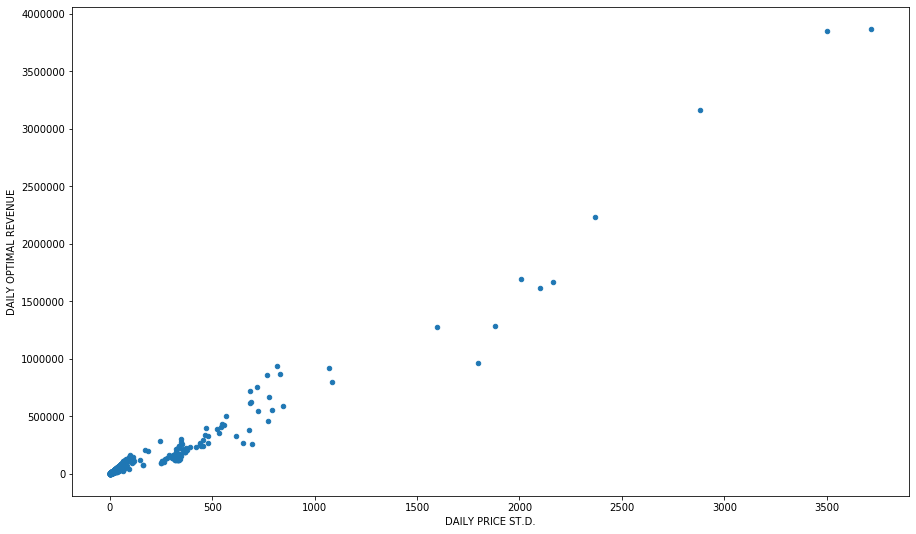

In [118]:
dailyRevenue_vs_daily_price_std_QLD = pd.DataFrame()

dailyRevenue_vs_daily_price_std_QLD['DAILY OPTIMAL REVENUE'] = \
df_QLD.OPTIMALREVENUE.rolling(48).sum()[list(range(47,len(df_QLD),48))]\
.reset_index(drop=True)

dailyRevenue_vs_daily_price_std_QLD['DAILY PRICE ST.D.'] = \
df_QLD.RRP.rolling(48).std()[list(range(47,len(df_QLD),48))]\
.reset_index(drop=True)

ax1 = dailyRevenue_vs_daily_price_std_QLD.plot.scatter(x='DAILY PRICE ST.D.',\
                                                       y = 'DAILY OPTIMAL REVENUE', figsize=(15,9))

We can see that there is a clearly linear correlation though in some cases it is hard to make estimations based only on that.

## ROADMAP:

Based on the above results, during the implementation of the capstone project we hope to achieve the following milestones:

- Drop the assumption of the day-ahead price knowledge and implement machine learning to develop a decision algorithm for the battery operation and estimate the realistict profit.
- Drop the assumption of non-price influence and factor in the price changes that will be 
- Drop the assumption of zero OPEX and factor in the objective function of the optimization algorithm an estimated OPEX per megawatt-hour
- Factor in the optimization algorithm a percentage of the battery capacity for ancillary services. The percentage itself will be determined from the objective function.
- Factor in the optimization algorithm a percentage of photovoltaics. The percentage of photovoltaics and their usage throughout the day will be determined by the optimization algorithm.

Ultimately, the developed tool will take as input an investment in millions and output the optimal percentages of BESS and photovoltaics, the area to invest, and the optimal operational strategy.

## FUTURE WORK:

There are a number of ways that this can be developed further such as:

- Factor in the response of other suppliers (game theory)
- Taylor for application to other markets
